#  Building an in-database Linear Regression Model using Db2's In-database ML Stored Procedures

I will show you the following steps of building and using a linear regression pipeline inside a Db2 database using Db2's in-database machine learning stored procedures, known as IDAX (in-database advanced analytics):

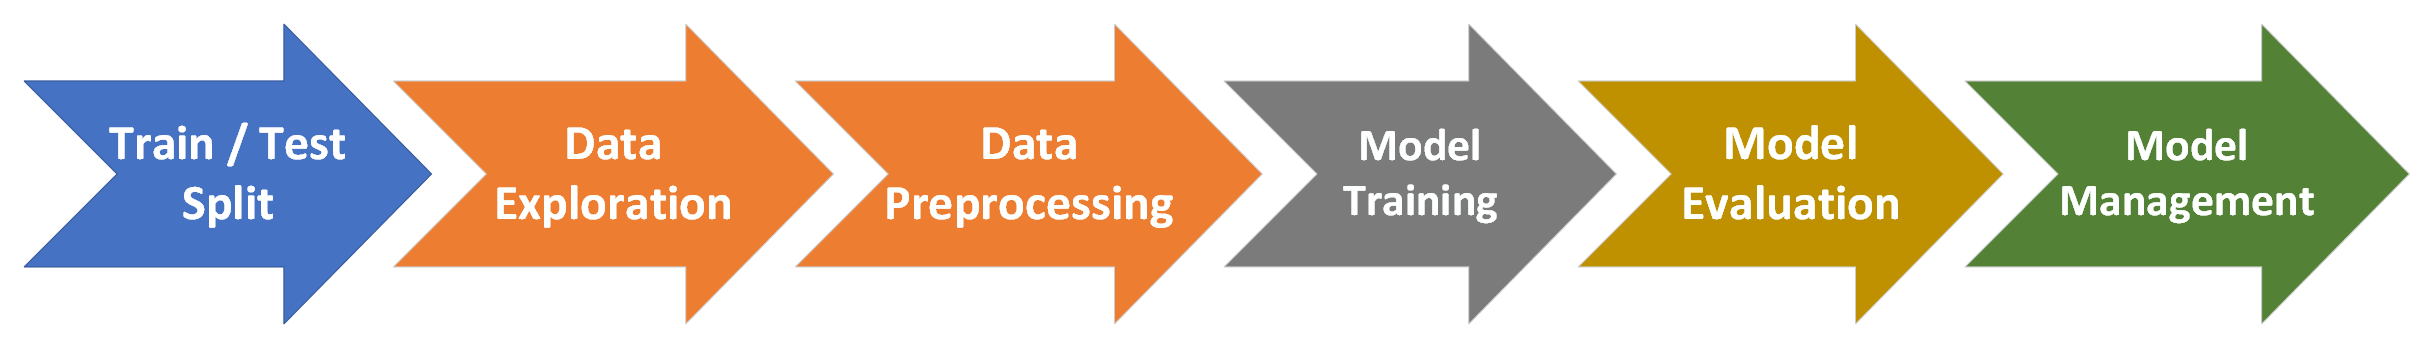

# Regression Task

In this exercise, I will use the GoSales dataset, which is available from [this](https://raw.githubusercontent.com/IBM/db2-samples/master/In_Db2_Machine_Learning/Building%20ML%20Models%20with%20Db2/Datasets/GoSalesSubSet/GoSalesSubSet.csv) link. The dataset has 60252 synthetic customers’ profile and their purchase amount at an imaginary outdoor equipment store. The following is the list of columns in the dataset:
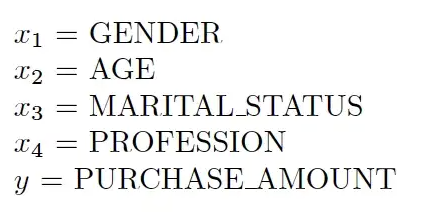


I want to learn a multiple linear regression function of the following equation form that will use as input the first four columns — AGE, MARITAL_STATUS, and PROFESSION — and predict the PURCHASE_AMOUNT.

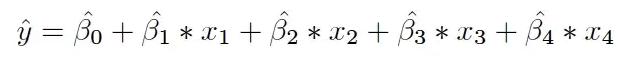

Using the training examples, the linear regression algorithm will learn the values of the following five parameters — the first one is the intercept and the remaining are four coefficients, one per input column.

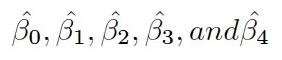

Following [these](https://github.com/IBM/db2-samples/blob/master/In_Db2_Machine_Learning/Building%20ML%20Models%20with%20Db2/Datasets/GoSalesSubSet/GoSalesSubSetReadMe.txt) steps, I created a Db2 table with the name GOSALES_FULL under GOSALES schema and loaded the [dataset](https://raw.githubusercontent.com/IBM/db2-samples/master/In_Db2_Machine_Learning/Building%20ML%20Models%20with%20Db2/Datasets/GoSalesSubSet/GoSalesSubSet.csv) into it.

# Packages installation and Imports 

In [1]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from dotenv import dotenv_values
!wget https://raw.githubusercontent.com/IBM/db2-jupyter/master/db2.ipynb
%run db2.ipynb

--2022-12-14 11:42:22--  https://raw.githubusercontent.com/IBM/db2-jupyter/master/db2.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130924 (128K) [text/plain]
Saving to: ‘db2.ipynb.1’

db2.ipynb.1         100%[===================>] 127.86K  --.-KB/s    in 0.08s   

2022-12-14 11:42:22 (1.51 MB/s) - ‘db2.ipynb.1’ saved [130924/130924]

Db2 Extensions Loaded.


In [3]:
pd.set_option('display.max_rows', 20)

# Load Db2 credentials from a config file

In [4]:
db2creds_file = 'db2-gosales.env'
db2creds = dotenv_values(db2creds_file)

# Connect to the Db2 database

In [5]:
%sql CONNECT CREDENTIALS db2creds

Connection successful.


# Clean up the database
This step is necessary when if this model and other generated tables from this notebook already exist in the schema from a previous run

In [6]:
# drop model using IDAX.DROP_MODEL SP
# doc: https://www.ibm.com/docs/en/db2/11.5?topic=management-idaxdrop-model-drop-model
%sql CALL IDAX.DROP_MODEL('model=GOSALES.GOSALES_LINREG')

# drop tables generated by IDAX.SUMMARY1000 SP
%sql CALL IDAX.DROP_SUMMARY1000('intable=GOSALES.GOSALES_TRAIN_SUM1000');

# drop train and test tables
%sql DROP TABLE GOSALES.GOSALES_TRAIN;
%sql DROP TABLE GOSALES.GOSALES_TEST;
%sql DROP TABLE GOSALES.GOSALES_TEST_PREDICTIONS

Command completed.
Command completed.
Command completed.


# 1 Train / Test split using [IDAX.SPLIT_DATA](https://www.ibm.com/docs/en/db2/11.5?topic=transformation-idaxsplit-data-split-data) SP

In [7]:
%sql CALL IDAX.SPLIT_DATA('intable=GOSALES.GOSALES_FULL, id=ID, traintable=GOSALES.GOSALES_TRAIN, testtable=GOSALES.GOSALES_TEST, fraction=0.8, seed=1')

,NUMROWS
0,48202


# Count the number of rows in the Train and Test Partitions

In [8]:
%sql SELECT count(*) FROM GOSALES.GOSALES_TRAIN

,1
0,48202.0


In [9]:
%sql SELECT count(*) FROM GOSALES.GOSALES_TEST

,1
0,12050.0


# 2 Data Exploration

Now, I will look into some sample records from the training dataset, GOSALES_TRAIN.

In [10]:
%sql SELECT * FROM GOSALES.GOSALES_TRAIN FETCH FIRST 5 ROWS ONLY

,ID,GENDER,AGE,MARITAL_STATUS,PROFESSION,PURCHASE_AMOUNT
0,16990,M,22,Single,Executive,138.37
1,23844,M,35,Single,Professional,164.72
2,20407,M,28,Married,Sales,138.61
3,21147,M,29,Married,Executive,164.09
4,39965,M,25,Single,Professional,144.78


From the above sample records, I get a feel for the customer records I will work with.

## Generating summary statistics of the entire training set using [IDAX.SUMMARY1000 SP](https://www.ibm.com/docs/en/db2/11.5?topic=exploration-idaxsummary1000-summary-up-1000-columns)

In [11]:
%sql CALL IDAX.SUMMARY1000('intable=GOSALES.GOSALES_TRAIN, outtable=GOSALES.GOSALES_TRAIN_SUM1000, incolumn=GENDER;AGE;MARITAL_STATUS;PROFESSION')

,NUMROWS
0,4


SUMMARY1000 SP saves the collected statistics from the training table in three output tables: (1) GOSALES_TRAIN_SUM1000: has summary statistics of all columns listed in the incolumn parameter; (2) GOSALES_TRAIN_SUM1000_NUM: has summary statistics of only the numeric columns from the incolumn parameter, (3) GOSALES_TRAIN_SUM1000_CHAR: has summary statistics of categorical columns from the incolumn parameter.

For the ease of viewing, I will look at the summary statistics of each column type separately — first the numeric type and then nominal type.

In [12]:
%sql SELECT * FROM GOSALES.GOSALES_TRAIN_SUM1000_NUM

,COLUMNNAME,COLUMNID,COUNTT,AVERAGE,VARIANCE,STDDEV,SKEWNESS,KURTOSIS,MINIMUM,MAXIMUM,MISSING
0,AGE,1,46356,34.17467,102.057355,10.102344,0.653102,0.058259,17.0,69.0,1846


The dataset has one numeric feature column, AGE. This summary table has provides a range of statistics, such as mean, variance, skewness. Also, the table reports that the AGE column has 1878 missing values.

Similarly, I find the following summary statistics from the GOSALES.GOSALES_TRAIN_SUM1000_CHAR table.

In [13]:
%sql SELECT * FROM GOSALES.GOSALES_TRAIN_SUM1000_CHAR

,COLNAME,DISTINCTVALUES,MOSTFREQUENTVALUE,MOSTFREQUENTCASES,NONMISSINGCASES,MISSING
0,GENDER,2,M,24017,46144,2058
1,MARITAL_STATUS,3,Married,24355,47582,620
2,PROFESSION,9,Other,19129,47002,1200


From this summary, I can see that all three nominal columns have some missing values.

# 3 Data Preprocessing

From data exploration, I identified two kinds of data preprocessing tasks: handling missing values and dealing with nominal columns. In this step, I will address both tasks.

## Dealing with missing values

### Replacing missing values in the training dataset using [IDAX.IMPUTE_DATA](https://www.ibm.com/docs/en/db2/11.5?topic=transformation-idaximpute-data-impute-missing-data) SP. 

This SP supports replacing missing values with one of the four methods: mean, median, most frequent value, or a constant. All four methods work with numeric columns, whereas only the last two methods apply to nominal columns.

### Imputing missing values in the Age column
I will replace missing values in the AGE column with the mean age value:

In [14]:
%sql CALL IDAX.IMPUTE_DATA('intable=GOSALES.GOSALES_TRAIN, incolumn=AGE, method=mean')

,NUMCOLS
0,1


In the above SP call, I passed three parameters: (1) intable: the name of the input table, which is GOSALES_TRAIN, (2) incolumn: the name of the column for imputing missing values. AGE is the column name. (3) method: a supported imputation strategy. I chose mean.)

Similarly, the following SP calls will replace missing values in GENDER, MARITAL_STATUS, and PROFESSION columns with the most frequent value of each column. I looked up the most frequent values of each column from the GOSALES_TRAIN_SUM1000_CHAR table that was created during the data exploration step.

### Imputing missing values in the GENDER column:

In [15]:
%sql CALL IDAX.IMPUTE_DATA('intable=GOSALES.GOSALES_TRAIN, method=replace, nominalValue=M, incolumn=GENDER')

,NUMCOLS
0,1


### Imputing missing values in the MARITAL_STATUS column:

In [16]:
%sql CALL IDAX.IMPUTE_DATA('intable=GOSALES.GOSALES_TRAIN, method=replace, nominalValue=Married, incolumn=MARITAL_STATUS')

,NUMCOLS
0,1


### Imputing missing values in the PROFESSION column:

In [17]:
%sql CALL IDAX.IMPUTE_DATA('intable=GOSALES.GOSALES_TRAIN, method=replace, nominalValue=Other, incolumn=PROFESSION')

,NUMCOLS
0,1


By running the following SQL statement, I can confirm that the AGE column in the training dataset is now free of any missing values:

In [18]:
%sql SELECT count(*) FROM GOSALES.GOSALES_TRAIN WHERE AGE IS NULL

,1
0,0.0


Similarly, the following statements will count missing values in GENDER, MARITAL_STATUS, and PROFESSION columns. All of them no longer have any missing value.

### Count missing values in the GENDER COLUMN:

In [19]:
%sql SELECT count(*) FROM GOSALES.GOSALES_TRAIN WHERE GENDER IS NULL

,1
0,0.0


### Count missing values in the PROFESSION column:

In [20]:
%sql SELECT count(*) FROM GOSALES.GOSALES_TRAIN WHERE PROFESSION IS NULL

,1
0,0.0


## Dealing with nominal columns

Linear regression algorithm requires that all its input columns are numeric. So, before invoking a linear regression algorithm, ML practitioners convert any non-numeric columns to numbers following some encoding scheme — such as 1-hot encoding. The linear regression SP of Db2 can natively handle nominal columns. When the input table has any nominal column, the SP internally converts it into a set of numeric columns using 1-hot encoding. So, I can leave the three nominal columns — GENDER, MARITAL_STATUS, and PROFESSION — as-is and let the SP take care of them.

#### Now, the GOSALES_TRAIN dataset is ready for model training.

# 4 Model Training 
## Using [IDAX.LINEAR_REGRESSION](https://www.ibm.com/docs/en/db2/11.5?topic=functions-idaxlinear-regression-build-linear-regression-model) SP

The following call to the IDAX.LINEAR_REGRESSION SP will begin training of a linear regression model using training examples from the GOSALES_TRAIN table. The SP will use the list of columns mentioned in the incolum paramter as input features and the column from the target parameter as the output column. Since the intercept parameter is set to true, the SP will learn the value of intercept.

In [21]:
%sql CALL IDAX.LINEAR_REGRESSION('model=GOSALES.GOSALES_LINREG, intable=GOSALES.GOSALES_TRAIN, id=ID, target=PURCHASE_AMOUNT,incolumn=AGE;GENDER;MARITAL_STATUS;PROFESSION, intercept=true')

,LINEAR_REGRESSION
0,t


## List Models

After the training completes, the SP will add the new model, GOSALES_LINREG, to Db2’s model catalog. The following SP call will show the list of existing models in the catalog, which now includes my new model.

In [22]:
%sql CALL IDAX.LIST_MODELS('format=short, all=true')

,MODELSCHEMA,MODELNAME,OWNER,CREATED,STATE,MININGFUNCTION,ALGORITHM,USERCATEGORY
0,FLIGHT,FLIGHT_DECTREE,SHAIKHQ,2022-11-22-08.18.27.496438,Complete,classification,Decision Tree,None
1,GOSALES,GOSALES_LINREG,SHAIKHQ,2022-12-14-08.42.46.004845,Complete,regression,Linear Regression,None


Additionally, the LINEAR_REGRESSION SP saves the learned values of intercept and the coefficients, along with several other learned parameter values, in a table. The table’s name takes this form: MODELNAME_MODEL. For the GOSALES_LINREG model, the name of its metadata table is GOSALES_LINREG_MODEL.

### Checking Model's Metadata

In [23]:
%sql SELECT VAR_NAME, LEVEL_NAME, VALUE FROM GOSALES.GOSALES_LINREG_MODEL

,VAR_NAME,LEVEL_NAME,VALUE
0,GENDER,F,20.575592
1,GENDER,M,41.272187
2,AGE,<NA>,0.043618
3,MARITAL_STATUS,Unspecified,11.912832
4,MARITAL_STATUS,Married,34.108556
...,...,...,...
11,PROFESSION,Sales,11.164951
12,PROFESSION,Professional,18.936674
13,PROFESSION,Retail,-4.870665
14,PROFESSION,Retired,-11.537529


# 5 Generating Predictions from the Trained Model

In this step, I will use the GOSALES_LINREG model to predict the purchase amount of the customers in the GOSALE_TEST table. Before generating predictions, I will preprocess this dataset using the preprocessing steps I had used with the training dataset, which were imputing missing values. I will use the following SQL statements to impute missing values in AGE, GENDER, MARITAL_STATUS, and PROFESSION columns of the test dataset.

## Imputing missing values in the TEST dataset

### Imputing missing values in the AGE column

In [24]:
%sql CALL IDAX.IMPUTE_DATA('intable=GOSALES.GOSALES_TEST, method=mean, incolumn=AGE')

,NUMCOLS
0,1


### Imputing missing values in the GENDER column

In [25]:
%sql CALL IDAX.IMPUTE_DATA('intable=GOSALES.GOSALES_TEST, method=replace, nominalValue=M, incolumn=GENDER')

,NUMCOLS
0,1


### Imputing missing values in the MARITAL_STATUS column

In [26]:
%sql CALL IDAX.IMPUTE_DATA('intable=GOSALES.GOSALES_TEST, method=replace, nominalValue=Married, incolumn=MARITAL_STATUS')

,NUMCOLS
0,1


### Imputing missing values in the PROFESSION column

In [27]:
%sql CALL IDAX.IMPUTE_DATA('intable=GOSALES.GOSALES_TEST, method=replace, nominalValue=Other, incolumn=PROFESSION')

,NUMCOLS
0,1


Now the test dataset is ready to be passed as input to the model.

### GENERATING predictions using [IDAX.PREDICT_LINEAR_REGRESSION](https://www.ibm.com/docs/en/db2/11.5?topic=functions-idaxpredict-linear-regression-apply-linear-regression) SP
PREDICT_LINEAR_REGRESSION SP will use GOSALES_LINREG model to generate predictions for records in the GOSALES_TEST table. The SP will save the predictions in the GOSALES_TEST_PREDICTIONS table, as per the table name specified in the outtable parameter.

In [28]:
%sql CALL IDAX.PREDICT_LINEAR_REGRESSION('model=GOSALES.GOSALES_LINREG, intable=GOSALES.GOSALES_TEST, outtable=GOSALES.GOSALES_TEST_PREDICTIONS, id=ID')

,PREDICT_LINEAR_REGRESSION
0,t


## View a few sample predictions from the results table
The following SQL displays sample predictions from the GOSALES_TEST_PREDICTIONS table.

In [29]:
%sql SELECT * FROM GOSALES.GOSALES_TEST_PREDICTIONS FETCH FIRST 5 ROWS ONLY

,ID,PURCHASE_AMOUNT
0,59891,104.928101
1,43046,150.142035
2,15534,127.429151
3,3739,140.609808
4,49989,126.905734


# 6 Model Evaluation
For the test customer records, the actual purchase price is available at the GOSALES_TEST table and the predicted purchase price is in the GOSALES_TEST_PREDICTIONS table. Based on these actual and the predicted purchase amounts, I can now compute Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percent Error (MAPE) via SQL. This will help me evaluate the model’s predictive performance.

# Mean Squared Error (MSE)
For computing MSE, I'll use [IDAX.MSE](https://www.ibm.com/docs/en/db2/11.5?topic=evaluation-idaxmse-calculate-mean-squared-error-regression-predictions) SP


In [30]:
%sql CALL IDAX.MSE('intable=GOSALES.GOSALES_TEST, id=ID, target=PURCHASE_AMOUNT, resulttable=GOSALES.GOSALES_TEST_PREDICTIONS, resulttarget=PURCHASE_AMOUNT')

,MSE
0,157.389626


## Mean Absolute Error (MAE)
For calculating MSE, I'll use [IDAX.MAE](https://www.ibm.com/docs/en/db2/11.5?topic=evaluation-idaxmae-calculate-mean-absolute-error-regression-predictions) SP

In [31]:
%sql CALL IDAX.MAE('intable=GOSALES.GOSALES_TEST, id=ID, target=PURCHASE_AMOUNT, resulttable=GOSALES.GOSALES_TEST_PREDICTIONS, resulttarget=PURCHASE_AMOUNT')

,MAE
0,10.460282


## Mean Abosolute Percent Error (MAPE)
I wrote the following SQL to compute MAPE:

In [32]:
%sql SELECT avg(abs(A.PURCHASE_AMOUNT - B.PURCHASE_AMOUNT) / A.PURCHASE_AMOUNT * 100) AS MAPE FROM GOSALES.GOSALES_TEST AS A, GOSALES.GOSALES_TEST_PREDICTIONS AS B WHERE A.ID = B.ID

,MAPE
0,8.266584
